# Task 2: Setup

In [1]:
!pip install -q pydub

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

from IPython.display import Audio
from matplotlib import pyplot as plt
from tqdm import tqdm

print(tf.__version__)
print(tfds.__version__)

2.5.0
4.0.1


In [3]:
dataset = tfds.load("gtzan_music_speech")

Shuffling and writing examples to /root/tensorflow_datasets/gtzan_music_speech/1.0.0.incompleteY7RT68/gtzan_music_speech-train.tfrecord


Dataset gtzan_music_speech downloaded and prepared to /root/tensorflow_datasets/gtzan_music_speech/1.0.0. Subsequent calls will reuse this data.


# Task 3: Explore the Data

In [4]:
train = dataset["train"]

data_iter = iter(train)

In [5]:
example=next(data_iter)
example

{'audio': <tf.Tensor: shape=(661500,), dtype=int64, numpy=array([-2821, -3743, -4288, ...,  -717,   132,  1548])>,
 'audio/filename': <tf.Tensor: shape=(), dtype=string, numpy=b'vlobos.wav'>,
 'label': <tf.Tensor: shape=(), dtype=int64, numpy=0>}

In [6]:
audio=example.get("audio")
label=example.get("label")
Audio(audio,rate=22050)

In [7]:
index_to_class = {0: "music", 1: "speech"}
class_to_index = {"music": 0, "speech": 1}

In [8]:
def plot_waveform(audio):
    plt.plot(audio)
    plt.xlabel("samples")
    plt.ylabel("amplitude")
    plt.show()

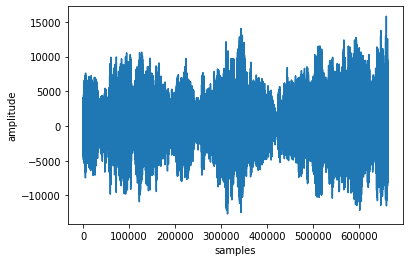

In [9]:
plot_waveform(audio)

# Task 4: Spectrogram

In [10]:
def get_stft(audio, frame_length=2048, frame_step=512, fft_length=256):
    return tf.signal.stft(
        tf.cast(audio, tf.float32),
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=fft_length
    )

In [11]:
aud_sht=get_stft(audio)
audio_spec=tf.abs(aud_sht)

In [12]:
def plot_spec(spec):
    plt.figure(figsize=(12, 4))
    plt.imshow(tf.transpose(spec), cmap="viridis")
    plt.colorbar()
    plt.show()

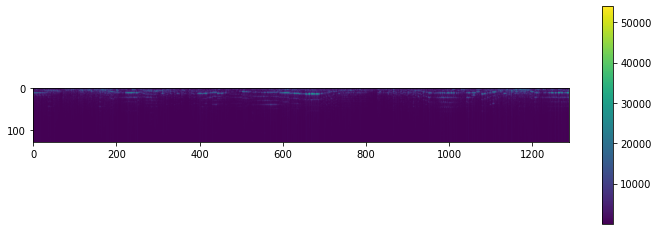

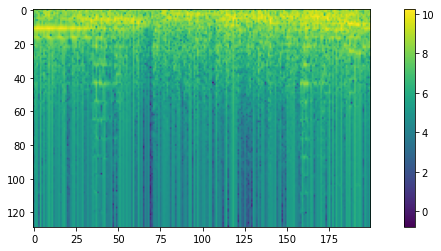

In [13]:
audio_spe=plot_spec(audio_spec)
aud_spec_log=tf.math.log(audio_spec)
plot_spec(aud_spec_log[:200])

In [14]:
def get_spectrogram(audio):
    audio_stft = get_stft(audio)
    audio_spec = tf.abs(audio_stft)
    return tf.math.log(tf.transpose(audio_spec))

# Task 5: Prepare the Data

In [15]:
sr = 22050 # samples per second
chunk_len = 5 # seconds


def preprocessing(example):
  audio=example.get("audio")
  lable=example.get("label")

  x_batch,y_batch=None,None

  for i in range(0,6):
    start_sample=i*chunk_len*sr
    end_sample=(i+1)*chunk_len*sr
    audio_chunk=audio[start_sample:end_sample]
    audio_spec=get_spectrogram(audio_chunk)
    audio_spec=tf.expand_dims(audio_spec,axis=0)
    current_label=tf.expand_dims(label,axis=0)


    x_batch=audio_spec if x_batch is None else tf.concat([x_batch,audio_spec],axis=0)
    y_batch=current_label if y_batch is None else tf.concat([y_batch,current_label],axis=0)
  return x_batch,y_batch

In [16]:
x_train,y_train =None,None

for i in tqdm(iter(train)):
   x_batch,y_batch=preprocessing(example)
  
   x_train=x_batch if x_train is None else tf.concat([x_train,x_batch],axis=0)  
   y_train=y_batch if y_train is None else tf.concat([y_train,y_batch],axis=0)

128it [00:04, 29.08it/s]


In [17]:
print(x_train.shape,y_train.shape)

(768, 129, 212) (768,)


In [18]:
indices = tf.random.shuffle(list(range(0, 768)))

x_train = tf.gather(x_train, indices)
y_train = tf.gather(y_train, indices)

n_val = 300

x_valid = x_train[:n_val, ...]
y_valid = y_train[:n_val, ...]

x_train = x_train[n_val:, ...]
y_train = y_train[n_val:, ...]

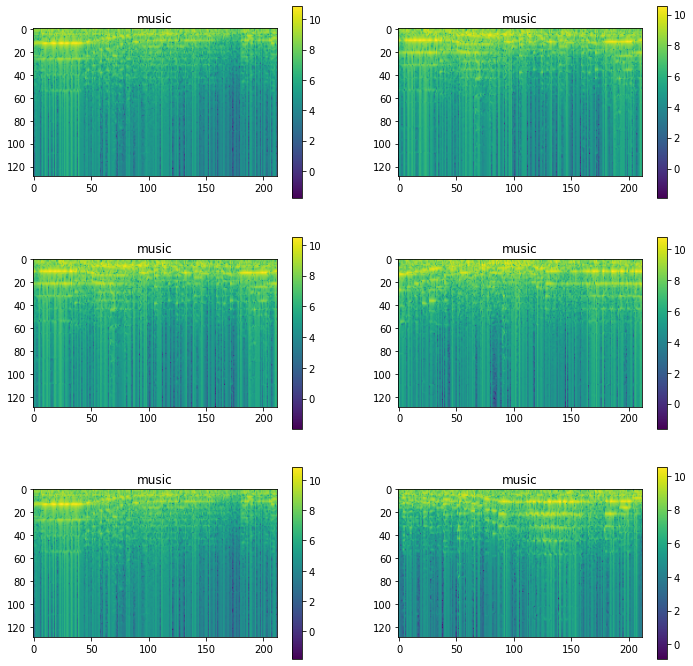

In [19]:
plt.figure(figsize=(12, 12))

st = 0

for i in range(0, 6):
    x, y = x_train[st + i], y_train[st + i]

    plt.subplot(3, 2, i + 1)
    plt.imshow(x, cmap="viridis")
    plt.title(index_to_class[y.numpy()])
    plt.colorbar()
plt.show()

# Task 6: Create the Model

In [29]:
from tensorflow.keras.layers import Input, Lambda, Conv2D, BatchNormalization
from tensorflow.keras.layers import Activation, MaxPool2D, Flatten, Dropout, Dense


input_=Input(shape=(129,212))
x=Lambda(lambda x:tf.expand_dims(x,axis=-1))(input_)

for i in range(0,4):
  num_filters=2**(5+i)
  x=Conv2D(num_filters,3)(x)
  x=BatchNormalization()(x)
  x=Activation("tanh")(x)
  x=MaxPool2D(2)(x)

x=Flatten()(x)
x=Dropout(0.4)(x)
x=Dense(128,activation="relu")(x)
x=Dropout(0.4)(x)
x=Dense(1,activation="sigmoid")(x)

model=tf.keras.models.Model(input_,x)

In [38]:
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-6),
    metrics=["accuracy"]
)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 129, 212)]        0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 129, 212, 1)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 127, 210, 32)      320       
_________________________________________________________________
batch_normalization_8 (Batch (None, 127, 210, 32)      128       
_________________________________________________________________
activation_8 (Activation)    (None, 127, 210, 32)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 63, 105, 32)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 61, 103, 64)       18496 

# Task 7: Model Training

In [32]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, *args, **kwargs):
        super(CustomCallback, self).__init__(*args, **kwargs)
        self.target_acc = kwargs.get("target_acc") or 0.95
        self.log_epoch = kwargs.get("log_epoch") or 5

    def on_epoch_end(self, epoch, logs=None):
        loss = logs.get("loss")
        acc = logs.get("accuracy")
        val_loss = logs.get("val_loss")
        val_acc = logs.get("val_accuracy")

        if (epoch + 1) % self.log_epoch == 0:
            print(f"Epoch: {epoch:3d}, Loss: {loss:.4f}, Acc: {acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_acc >= self.target_acc:
            print("Target val accuracy achieved", val_acc)
            model.stop_training = True

In [37]:
_ =model.fit(
    x_train,y_train
    ,validation_data=(x_valid,y_valid),
    batch_size=12,
    epochs=500,verbose=False,callbacks=[CustomCallback()]
)

Target val accuracy achieved 1.0


# Task 8: Predictions

In [40]:
example=next(data_iter)
x_test,y_test=preprocessing(example)
prediction=model.predict(x_test)
y_classes=tf.squeeze(tf.cast(prediction>0.5,tf.int8))

In [41]:
y_classes

<tf.Tensor: shape=(6,), dtype=int8, numpy=array([0, 0, 0, 0, 0, 0], dtype=int8)>

In [42]:
y_test

<tf.Tensor: shape=(6,), dtype=int64, numpy=array([0, 0, 0, 0, 0, 0])>